# Experiment x-4
Applying feature selection to elliptic dataset

In [85]:
from efc import EnergyBasedFlowClassifier

In [93]:
from matplotlib import pyplot as plt

In [172]:
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix
)

In [92]:
results_efc = 'results/efc/experiment-x-4'

In [95]:
# make experiments results dir if not exists
if not os.path.exists(results_efc):
    os.makedirs(results_efc)

## Common Functions

In [102]:
def calculate_model_score(y_true, y_pred):
    metric_dict = {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred, average="weighted"),
        "f1_micro": f1_score(y_true, y_pred, average="micro"),
        "f1_macro": f1_score(y_true, y_pred, average="macro"),
        "precision": precision_score(y_true, y_pred, average="weighted"),
        "recall": recall_score(y_true, y_pred, average="weighted"),
    }
    return metric_dict

In [144]:
def train_test_from_splitted(X_train, y_train, X_test, y_test, return_df=False):
    df_train = pd.concat([X_train, y_train], axis=1)
    df_test = pd.concat([X_test, y_test], axis=1)
    df = pd.concat([df_train, df_test])
    X = df.drop(['class'], axis=1)
    y = df['class']

    if return_df:
        df_train = pd.concat([X_train, y_train], axis=1)
        df_test = pd.concat([X_test, y_test], axis=1)
        df_new = pd.concat([df_train, df_test])
        return df_new

    return X, y  

In [143]:
def recreate_original_df():
    last_time_step = 49
    last_train_time_step = 34
    only_labeled = True
    X_train, X_test, y_train, y_test = run_elliptic_preprocessing_pipeline(last_train_time_step=last_train_time_step,
                                                                             last_time_step=last_time_step,
                                                                             only_labeled=only_labeled)
    df_train = pd.concat([X_train, y_train], axis=1)
    df_test = pd.concat([X_test, y_test], axis=1)
    df = pd.concat([df_train, df_test])

    return df

In [158]:
from sklearn.model_selection import train_test_split as sklearn_train_test_split

def train_test_from_x_y(X, y, last_train_time_step, last_time_step):
    X_train_df, X_test_df, y_train, y_test = sklearn_train_test_split(X, y, random_state=139, stratify=y, shuffle=True, test_size=0.3)

    return X_train_df, X_test_df, y_train, y_test

## Dataset

In [1]:
import os
import sys

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
ROOT_DIR = os.getcwd()
sys.path.insert(0, ROOT_DIR)

In [3]:
def combine_dataframes(df_classes, df_features, only_labeled=True):
    df_combined = pd.merge(
        df_features, df_classes, left_on="id", right_on="txId", how="left"
    )
    if only_labeled == True:
        df_combined = df_combined[df_combined["class"] != 2].reset_index(drop=True)
    df_combined.drop(columns=["txId"], inplace=True)
    return df_combined

In [4]:
def rename_classes(df_classes):
    df_classes.replace({"class": {"1": 1, "2": 0, "unknown": 2}}, inplace=True)
    return df_classes

In [5]:
def rename_features(df_features):
    df_features.columns = (
        ["id", "time_step"]
        + [f"trans_feat_{i}" for i in range(93)]
        + [f"agg_feat_{i}" for i in range(72)]
    )
    return df_features

In [6]:
def import_elliptic_data_from_csvs():
    df_classes = pd.read_csv(
        os.path.join(ROOT_DIR, "datasets/elliptic/elliptic_txs_classes.csv")
    )
    df_edges = pd.read_csv(
        os.path.join(ROOT_DIR, "datasets/elliptic/elliptic_txs_edgelist.csv")
    )
    df_features = pd.read_csv(
        os.path.join(ROOT_DIR, "datasets/elliptic/elliptic_txs_features.csv"),
        header=None,
    )
    return df_classes, df_edges, df_features

In [7]:
def setup_train_test_idx(
    X, last_train_time_step, last_time_step, aggregated_timestamp_column="time_step"
):
    """The aggregated_time_step_column needs to be a column with integer values, such as year, month or day"""

    split_timesteps = {}

    split_timesteps["train"] = list(range(last_train_time_step + 1))
    split_timesteps["test"] = list(range(last_train_time_step + 1, last_time_step + 1))

    train_test_idx = {}
    train_test_idx["train"] = X[
        X[aggregated_timestamp_column].isin(split_timesteps["train"])
    ].index
    train_test_idx["test"] = X[
        X[aggregated_timestamp_column].isin(split_timesteps["test"])
    ].index

    return train_test_idx

In [8]:
def train_test_split(X, y, train_test_idx):
    X_train_df = X.loc[train_test_idx["train"]]
    X_test_df = X.loc[train_test_idx["test"]]

    y_train = y.loc[train_test_idx["train"]]
    y_test = y.loc[train_test_idx["test"]]

    return X_train_df, X_test_df, y_train, y_test

In [9]:
def load_elliptic_data(only_labeled=True, drop_node_id=True):
    df_classes, df_edges, df_features = import_elliptic_data_from_csvs()
    df_features = rename_features(df_features)
    df_classes = rename_classes(df_classes)
    df_combined = combine_dataframes(df_classes, df_features, only_labeled)

    if drop_node_id == True:
        X = df_combined.drop(columns=["id", "class"])
    else:
        X = df_combined.drop(columns="class")

    y = df_combined["class"]

    return X, y

In [10]:
def load_elliptic_data(only_labeled=True, drop_node_id=True):
    df_classes, df_edges, df_features = import_elliptic_data_from_csvs()
    df_features = rename_features(df_features)
    df_classes = rename_classes(df_classes)
    df_combined = combine_dataframes(df_classes, df_features, only_labeled)

    if drop_node_id == True:
        X = df_combined.drop(columns=["id", "class"])
    else:
        X = df_combined.drop(columns="class")

    y = df_combined["class"]

    return X, y

In [16]:
def run_elliptic_preprocessing_pipeline(
    last_train_time_step, last_time_step, only_labeled=True, drop_node_id=True,
    only_x_y=False
):
    X, y = load_elliptic_data(only_labeled, drop_node_id)
    if only_x_y:
        return X, y
    train_test_idx = setup_train_test_idx(X, last_train_time_step, last_time_step)
    X_train_df, X_test_df, y_train, y_test = train_test_split(X, y, train_test_idx)

    return X_train_df, X_test_df, y_train, y_test

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

## Decreasing Features
The original dataset contains 167 features, making EFC not learning well the anomolous class. We want to decrease the number of features in an atempt to improve EFC learning on malicious class.

### Feature selection wit sklearn

#### feature selection score function f_classif k = 16

In [74]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2

In [ ]:
# Elliptic data set timestep
last_time_step = 49
last_train_time_step = 34
only_labeled = True

In [65]:
X, y = run_elliptic_preprocessing_pipeline(
    last_train_time_step=last_train_time_step,
    last_time_step=last_time_step,
    only_x_y=True
)

/var/folders/8b/c9dvlw851kx2vf3r7gc5gbbh0000gn/T/ipykernel_47895/3533226547.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_classes.replace({"class": {"1": 1, "2": 0, "unknown": 2}}, inplace=True)


In [67]:
X.shape

(46564, 166)

for chi2 scoring function, X values must be non-negative

In [76]:
X_new = SelectKBest(f_classif, k=16).fit_transform(X, y)

In [77]:
X_new.shape

(46564, 16)

In [78]:
X_new

array([[-0.41400813,  4.18119239,  4.34663973, ..., -1.0598684 ,
        -0.21681436, -0.57709938],
       [-0.27112413,  3.68552898,  3.63375331, ..., -1.0598684 ,
        -0.21681436, -0.57709938],
       [-0.41395175, -0.48829574, -0.23255262, ..., -1.0598684 ,
        -0.21681436, -0.57709938],
       ...,
       [-0.41388414,  0.66986851,  1.77421454, ..., -0.45332953,
         0.3276244 ,  1.70962271],
       [ 3.15409476,  2.47923489, -0.23255262, ..., -1.0598684 ,
        -0.21681436, -0.57709938],
       [ 0.83152309,  0.68956737,  0.02127675, ..., -1.0598684 ,
         1.74789942,  1.26124583]])

##### EFC with feature selection

In [79]:
df_fs = pd.DataFrame(data=X_new)

In [80]:
df_fs

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.414008,4.181192,4.346640,1.777963,0.216750,0.216948,0.717108,0.810879,-0.694235,2.084651,0.856163,-0.163577,-0.425896,-1.059868,-0.216814,-0.577099
1,-0.271124,3.685529,3.633753,1.349956,0.216750,0.216948,0.717108,0.810879,-0.694235,2.084651,1.152253,-0.163577,-0.425896,-1.059868,-0.216814,-0.577099
2,-0.413952,-0.488296,-0.232553,-0.467503,-0.264408,-0.262405,-0.259232,-0.711861,-0.633648,-0.676279,-0.349933,-0.168742,-0.968903,-1.059868,-0.216814,-0.577099
3,-0.414002,-0.488337,-0.232553,-0.467551,-0.263830,-0.262097,-0.258919,-0.415344,-0.275094,-0.411789,-0.349933,-0.168742,-0.968903,-1.059868,-0.216814,-0.539735
4,-0.413200,2.759210,5.899000,2.030537,-0.264425,-0.262424,-0.259251,-0.761259,-0.693529,-0.720231,0.682652,-0.168742,-0.968903,-1.059868,-0.193143,-0.577099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46559,1.755516,1.316043,-0.232553,1.614191,8.063037,8.556144,2.734597,2.042339,1.006039,1.186074,-0.349933,-0.123309,-0.968903,0.951793,-0.216814,1.793987
46560,1.650708,1.228874,-0.232553,1.513623,-0.264408,-0.262405,-0.259213,-0.761253,-0.694235,-0.719700,-0.349933,3.059448,2.289138,-1.059868,2.150311,-0.577099
46561,-0.413884,0.669869,1.774215,0.335680,-0.264425,-0.262424,-0.259251,-0.761754,-0.693987,-0.720777,0.682652,0.188319,1.746131,-0.453330,0.327624,1.709623
46562,3.154095,2.479235,-0.232553,2.956185,2.018825,2.295907,2.346092,1.690401,1.788337,1.822639,-0.349933,-0.141406,1.203124,-1.059868,-0.216814,-0.577099


In [82]:
train_test_idx = setup_train_test_idx(X, last_train_time_step=last_train_time_step, last_time_step=last_time_step)
X_train_df, X_test_df, y_train, y_test = train_test_split(df_fs, y, train_test_idx)

In [86]:
sizes = {
    "X Size": len(X_train_df) + len(X_test_df),
    "y Size": len(y_train) + len(y_test),
    "X_train Size": len(X_train_df),
    "X_test Size": len(X_test_df),
    "y_train Size": len(y_train),
    "y_test Size": len(y_test),
    "y_train Malicious Size": len(np.where(y_train == 1)[0]),
    "y_train Bening Size": len(np.where(y_train == 0)[0]),
    "y_test Malicious Size": len(np.where(y_test == 1)[0]),
    "y_test Bening Size": len(np.where(y_test == 0)[0]),
}

In [87]:
df_sizes = pd.DataFrame(data=sizes, index=[0])

In [88]:
df_sizes

,X Size,y Size,X_train Size,X_test Size,y_train Size,y_test Size,y_train Malicious Size,y_train Bening Size,y_test Malicious Size,y_test Bening Size
0,46564,46564,29894,16670,29894,16670,3462,26432,1083,15587


In [97]:
clf = EnergyBasedFlowClassifier(n_bins=30, cutoff_quantile=0.9, pseudocounts=0.1)

In [98]:
clf.fit(X_train_df, y_train)

EnergyBasedFlowClassifier(cutoff_quantile=0.9, pseudocounts=0.1)

In [99]:
y_pred, y_energies = clf.predict(X_test_df, return_energies=True)

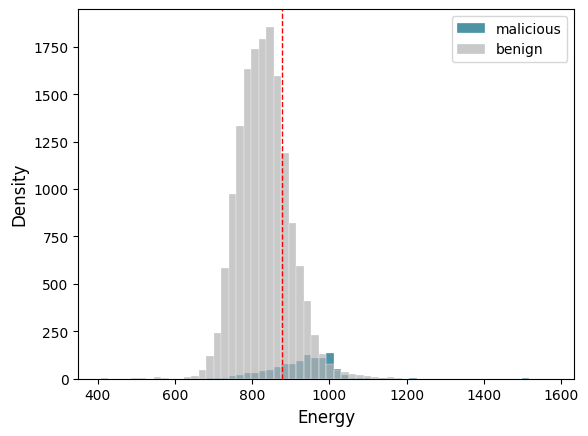

In [117]:
# ploting energies
benign = np.where(y_test == 0)[0]
malicious = np.where(y_test == 1)[0]

benign_energies = y_energies[benign]
malicious_energies = y_energies[malicious]
cutoff = clf.estimators_[0].cutoff_

bins = np.histogram(y_energies, bins=60)[1]

plt.hist(
    malicious_energies,
    bins,
    facecolor="#006680",
    alpha=0.7,
    ec="white",
    linewidth=0.3,
    label="malicious",
)
plt.hist(
    benign_energies,
    bins,
    facecolor="#b3b3b3",
    alpha=0.7,
    ec="white",
    linewidth=0.3,
    label="benign",
)
plt.axvline(cutoff, color="r", linestyle="dashed", linewidth=1)
plt.legend()

plt.xlabel("Energy", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.savefig(f'{results_efc}/1_feature_selection_score_function_f_classif_k_16')

##### EFC with feature selection metrics

In [104]:
model_score = calculate_model_score(y_true=y_test.values, y_pred=y_pred)

In [105]:
model_score

{'accuracy': 0.7718656268746251,
 'f1': np.float64(0.8272161601009076),
 'f1_micro': np.float64(0.7718656268746251),
 'f1_macro': np.float64(0.5837208207275375),
 'precision': np.float64(0.9280956512198568),
 'recall': np.float64(0.7718656268746251)}

In [106]:
df_efc_metrics = pd.DataFrame(data=model_score, index=[0])

In [107]:
df_efc_metrics

,accuracy,f1,f1_micro,f1_macro,precision,recall
0,0.771866,0.827216,0.771866,0.583721,0.928096,0.771866


In [108]:
labels_cm = ["True Negative", "False positive", "False Negative", "True Positive"]

In [109]:
cm = confusion_matrix(y_test, y_pred, labels=[1, 0])

In [110]:
cm = np.reshape(cm, -1).tolist()

In [111]:
cm

[830, 253, 3550, 12037]

In [113]:
confusion_matrix_values_1 = {'Technique': 'feature selection score function f_classif k = 16'} | {label: val for val, label in zip(cm, labels_cm)}

In [114]:
confusion_matrix_values_1

{'Technique': 'All labeled samples',
 'True Negative': 830,
 'False positive': 253,
 'False Negative': 3550,
 'True Positive': 12037}

In [ ]:
df_efc_confusion_matrix = pd.DataFrame(data=confusion_matrix_values_1,
                                       columns=["Technique", "True Negative", "False positive", "False Negative", "True Positive"],
                                       index=[0]
)

#### feature selection score function f_classif k = 16, removing aggregate columns from dataset

##### removing aggregate columns from dataset
recreating X and y from X_train, y_train, X_test, y_test

In [132]:
# Elliptic data set timestep
last_time_step = 49
last_train_time_step = 34
only_labeled = True

In [133]:
X_train, X_test, y_train, y_test = run_elliptic_preprocessing_pipeline(
    last_train_time_step=last_train_time_step,
    last_time_step=last_time_step,
    only_labeled=only_labeled,
)

/var/folders/8b/c9dvlw851kx2vf3r7gc5gbbh0000gn/T/ipykernel_47895/3533226547.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_classes.replace({"class": {"1": 1, "2": 0, "unknown": 2}}, inplace=True)


In [134]:
X_train.drop(columns=[f"agg_feat_{i}" for i in range(72)], axis=1, inplace=True)

In [135]:
X_test.drop(columns=[f"agg_feat_{i}" for i in range(72)], axis=1, inplace=True)

In [136]:
y_train.drop(columns=[f"agg_feat_{i}" for i in range(72)], axis=1, inplace=True)

In [137]:
y_test.drop(columns=[f"agg_feat_{i}" for i in range(72)], axis=1, inplace=True)

In [138]:
sizes = {
    "X Size": len(X_train) + len(X_test),
    "y Size": len(y_train) + len(y_test),
    "X_train Size": len(X_train),
    "X_test Size": len(X_test),
    "y_train Size": len(y_train),
    "y_test Size": len(y_test),
    "y_train Malicious Size": len(np.where(y_train == 1)[0]),
    "y_train Bening Size": len(np.where(y_train == 0)[0]),
    "y_test Malicious Size": len(np.where(y_test == 1)[0]),
    "y_test Bening Size": len(np.where(y_test == 0)[0]),
}

In [139]:
df_sizes = pd.DataFrame(data=sizes, index=[0])

In [140]:
df_sizes

,X Size,y Size,X_train Size,X_test Size,y_train Size,y_test Size,y_train Malicious Size,y_train Bening Size,y_test Malicious Size,y_test Bening Size
0,46564,46564,29894,16670,29894,16670,3462,26432,1083,15587


In [146]:
X, y = train_test_from_splitted(X_train, y_train, X_test, y_test, return_df=False)

##### feature selection with sklearn

In [147]:
X.shape

(46564, 94)

In [148]:
X_new = SelectKBest(f_classif, k=16).fit_transform(X, y)

In [149]:
X_new.shape

(46564, 16)

In [150]:
X_new

array([[-0.41400813,  4.18119239,  4.34663973, ...,  0.81087855,
        -0.6942352 ,  2.08465074],
       [-0.27112413,  3.68552898,  3.63375331, ...,  0.81087855,
        -0.6942352 ,  2.08465074],
       [-0.41395175, -0.48829574, -0.23255262, ..., -0.71186099,
        -0.63364772, -0.6762787 ],
       ...,
       [-0.41388414,  0.66986851,  1.77421454, ..., -0.76175378,
        -0.69398672, -0.72077698],
       [ 3.15409476,  2.47923489, -0.23255262, ...,  1.69040136,
         1.78833698,  1.82263919],
       [ 0.83152309,  0.68956737,  0.02127675, ..., -0.61774633,
        -0.52007978, -0.59215426]])

In [160]:
X_train, X_test, y_train, y_test = train_test_from_x_y(X_new,
                                                       y,
                                                       last_train_time_step=last_train_time_step,
                                                       last_time_step=last_time_step
)

##### efc with feature selection

In [161]:
clf = EnergyBasedFlowClassifier(n_bins=30, cutoff_quantile=0.9, pseudocounts=0.1)

In [162]:
clf.fit(X_train, y_train)

EnergyBasedFlowClassifier(cutoff_quantile=0.9, pseudocounts=0.1)

In [163]:
y_pred, y_energies = clf.predict(X_test_df, return_energies=True)

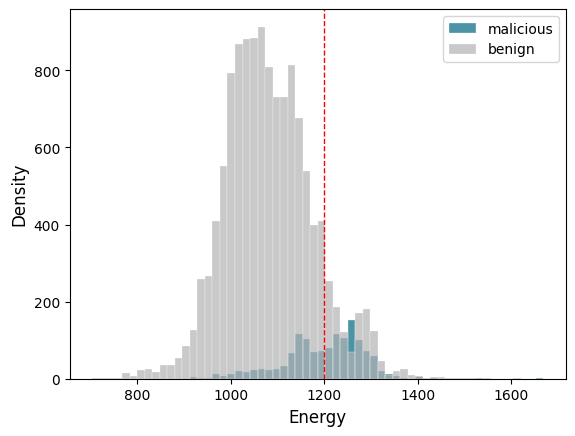

In [164]:
# ploting energies
benign = np.where(y_test == 0)[0]
malicious = np.where(y_test == 1)[0]

benign_energies = y_energies[benign]
malicious_energies = y_energies[malicious]
cutoff = clf.estimators_[0].cutoff_

bins = np.histogram(y_energies, bins=60)[1]

plt.hist(
    malicious_energies,
    bins,
    facecolor="#006680",
    alpha=0.7,
    ec="white",
    linewidth=0.3,
    label="malicious",
)
plt.hist(
    benign_energies,
    bins,
    facecolor="#b3b3b3",
    alpha=0.7,
    ec="white",
    linewidth=0.3,
    label="benign",
)
plt.axvline(cutoff, color="r", linestyle="dashed", linewidth=1)
plt.legend()

plt.xlabel("Energy", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.savefig(f'{results_efc}/2_feature_selection_score_function_f_classif_k_16_no_aggregated_columns')

##### EFC metrics

In [165]:
model_score = calculate_model_score(y_true=y_test.values, y_pred=y_pred)

In [166]:
model_score

{'accuracy': 0.8632068718682891,
 'f1': np.float64(0.8748124141102307),
 'f1_micro': np.float64(0.8632068718682891),
 'f1_macro': np.float64(0.679790731174645),
 'precision': np.float64(0.8911021667586099),
 'recall': np.float64(0.8632068718682891)}

In [167]:
df_efc_metrics.loc[1] = model_score

In [168]:
df_efc_metrics

,accuracy,f1,f1_micro,f1_macro,precision,recall
0,0.771866,0.827216,0.771866,0.583721,0.928096,0.771866
1,0.863207,0.874812,0.863207,0.679791,0.891102,0.863207


In [170]:
labels_cm = ["True Negative", "False positive", "False Negative", "True Positive"]

In [173]:
cm = confusion_matrix(y_test, y_pred, labels=[1, 0])

In [174]:
cm = np.reshape(cm, -1).tolist()

In [175]:
cm

[743, 621, 1290, 11316]

In [176]:
confusion_matrix_values_2 = {'Technique': 'feature selection score function f_classif k = 16 no aggregated columns'} | {label: val for val, label in zip(cm, labels_cm)}

In [177]:
confusion_matrix_values_2

{'Technique': 'feature selection score function f_classif k = 16 no aggregated columns',
 'True Negative': 743,
 'False positive': 621,
 'False Negative': 1290,
 'True Positive': 11316}

In [ ]:
df_efc_confusion_matrix.loc[1] = confusion_matrix_values_2

### PCA

#### Preprocess the Dataset
The features are all on different scales. To bring them all to a common scale, we’ll use the StandardScaler that transforms the features to have zero mean and unit variance

In [21]:
from sklearn.preprocessing import StandardScaler

In [24]:
std_scaler = StandardScaler()
df_scaled = std_scaler.fit_transform(df)

In [23]:
df.head()

,time_step,trans_feat_0,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,trans_feat_8,...,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71,class
0,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,-0.115831,...,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,0
1,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,-0.163645,-0.144554,...,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792,0
2,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.137933,-0.144108,...,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0
3,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.141519,-0.147643,...,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0
4,1,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,-0.029140,0.242712,-0.163640,-0.169115,...,-0.600999,0.241128,0.241406,0.018279,-0.068266,-0.084674,-0.054450,-1.760926,-1.760984,0


In [26]:
df_scaled

array([[-1.55687812,  0.30702549,  1.16882093, ..., -0.08332004,
        -0.08205159, -0.32888502],
       [-1.55687812,  0.06777975,  0.27191143, ..., -0.08332004,
        -0.08205159, -0.32888502],
       [-1.55687812, -0.13551708, -0.22264614, ..., -0.08332004,
        -0.08205159, -0.32888502],
       ...,
       [ 1.60978159, -0.16762877, -0.15366794, ..., -0.08332004,
        -0.08205159,  3.04057635],
       [ 1.60978159, -0.05848288, -0.17827679, ..., -0.08332004,
        -0.08205159, -0.32888502],
       [ 1.60978159, -0.16990809, -0.15367967, ..., -0.08332004,
        -0.08205159,  3.04057635]])

#### Apply PCA on the Preprocessed Dataset
The number of principal components is the number of dimensions that you’d like to reduce the feature space to

In [28]:
from sklearn.decomposition import PCA

In [51]:
n_components = 27
pca = PCA(n_components=n_components, svd_solver='full')
pca.fit_transform(df_scaled)

array([[ 0.34457844, -3.66413025,  3.56273776, ..., -1.86035372,
        -2.24872767,  0.43341381],
       [ 0.25562841, -3.65991645,  1.43792025, ...,  0.12289469,
        -1.74936422, -0.13458222],
       [-2.54949133, -4.56475411, -0.14570137, ...,  0.25691608,
         0.16440279, -1.44230193],
       ...,
       [-3.90076907,  4.61310512,  0.22765369, ...,  2.01644977,
         0.9404452 , -0.57569337],
       [ 3.51386375,  5.29854655, -3.16517453, ..., -0.34978699,
         0.86662784, -0.22292302],
       [-2.16588448,  4.11045745, -0.18586454, ..., -0.78973606,
         2.11328564, -0.43209535]])

#### Analyzing PCA Results

In [52]:
pca.components_

array([[-5.94748620e-02,  4.35736015e-02, -1.85747020e-02, ...,
         2.47000473e-02,  2.48244205e-02, -3.99544248e-02],
       [ 2.18369524e-01,  9.25356559e-02,  5.20501395e-02, ...,
        -3.91630943e-04, -3.88506754e-04, -1.32744190e-02],
       [-1.41559456e-03,  2.36154691e-01,  7.13917451e-02, ...,
        -6.22668527e-03, -6.58300766e-03, -2.55833603e-02],
       ...,
       [-3.32004984e-02,  4.69364015e-03, -3.03230446e-02, ...,
        -4.25789913e-02, -4.27774203e-02,  1.33925604e-02],
       [ 3.84843560e-02,  3.49681846e-02, -3.29384366e-02, ...,
        -1.87058662e-01, -1.86929396e-01,  1.58743369e-01],
       [ 1.61890921e-02,  2.07125809e-02,  1.05809989e-03, ...,
         5.34459561e-01,  5.35002103e-01,  2.82975591e-02]])

In [53]:
len(pca.components_)

27

In [54]:
total_variance = sum(pca.explained_variance_ratio_)

In [55]:
print(f"Here, we see that {n_components} principal components capture over {total_variance * 100:.2f}% of total variance in the dataset")

Here, we see that 27 principal components capture over 73.73% of total variance in the dataset


#### EFC with PCA

In [59]:
pca.components_[0]

array([-0.05947486,  0.0435736 , -0.0185747 , -0.08170965, -0.01411799,
        0.00059108, -0.01489151, -0.00048854,  0.04107678,  0.04329961,
        0.0196294 ,  0.04380183, -0.06659124, -0.06530058,  0.00058809,
        0.00295288,  0.01073383,  0.04286898,  0.04698863,  0.03903899,
        0.02789617,  0.03015706,  0.1172012 ,  0.14270053,  0.09303158,
        0.14455625,  0.00936936,  0.00935962,  0.1172016 ,  0.14269835,
        0.09303184,  0.14455679,  0.00935879,  0.00934661,  0.02300544,
        0.02402567,  0.01105319,  0.02374397,  0.01198995,  0.01204281,
        0.125444  ,  0.1456681 ,  0.0753465 ,  0.13898652,  0.01861518,
        0.02021099,  0.12546396,  0.14746614,  0.09185043,  0.13795919,
        0.01759594,  0.01916348,  0.14263337,  0.14775607,  0.05743328,
        0.16111398,  0.01224341,  0.01325424,  0.01188504,  0.15117803,
        0.14908882,  0.14442089,  0.12249369,  0.12324873,  0.01186184,
        0.15117791,  0.14908656,  0.14441731,  0.12249959,  0.12

In [60]:
df_efc = pd.DataFrame(data=pca.components_)

In [61]:
df_efc

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,-0.059475,0.043574,-0.018575,-0.081710,-0.014118,0.000591,-0.014892,-0.000489,0.041077,0.043300,...,-0.012119,-0.046360,-0.046722,0.000420,0.002255,-0.000340,-0.003931,0.024700,0.024824,-0.039954
1,0.218370,0.092536,0.052050,0.189668,0.007689,0.007793,0.008367,-0.000722,0.090420,0.090727,...,0.063603,-0.012144,-0.012733,-0.004543,0.022645,0.027008,0.027910,-0.000392,-0.000389,-0.013274
2,-0.001416,0.236155,0.071392,0.005955,0.062113,0.024422,0.060689,0.036686,0.180432,0.210655,...,0.019089,0.010365,0.010095,0.014653,0.050831,0.044218,0.037988,-0.006227,-0.006583,-0.025583
3,0.063046,-0.034408,0.035741,0.004033,0.021106,0.003918,0.022559,-0.003380,-0.041457,-0.035506,...,0.043933,0.008996,0.009267,-0.003523,0.004577,0.004502,0.004302,0.025540,0.025173,0.000777
4,-0.082663,0.075888,-0.020094,-0.030766,-0.001264,0.004119,-0.002875,0.008648,0.069253,0.069750,...,-0.035043,0.010457,0.010444,0.001713,0.007327,0.003342,-0.001652,-0.006019,-0.006296,0.014122
5,-0.087448,0.128086,-0.040960,-0.019750,-0.012129,-0.007440,-0.014546,0.007260,0.119518,0.120355,...,-0.106791,0.104385,0.103671,0.003099,0.005515,0.003964,-0.001988,0.027156,0.026690,0.036557
6,0.059748,-0.077275,0.142833,0.058684,0.154340,-0.029389,0.151960,0.075882,-0.117616,-0.104885,...,-0.142476,0.208699,0.209276,0.062884,-0.016983,-0.011455,0.019898,-0.058578,-0.058759,-0.037064
7,0.075543,0.025789,-0.131729,-0.000429,-0.177304,-0.008576,-0.174873,-0.081170,0.077801,0.054768,...,-0.116302,0.196792,0.196327,-0.042019,-0.015090,-0.013298,-0.028351,-0.050075,-0.050607,0.031261
8,0.078636,-0.100181,-0.057729,-0.025373,-0.084566,-0.062565,-0.083216,-0.038901,-0.085494,-0.135152,...,-0.112182,-0.141154,-0.141194,0.006210,-0.098474,-0.092351,-0.073357,0.001820,0.002178,0.090990
9,-0.086596,-0.121266,0.002926,-0.002376,-0.005374,0.027772,-0.002718,-0.017163,-0.119609,-0.144578,...,0.244011,0.169648,0.169797,-0.031276,-0.007252,-0.012958,-0.019056,-0.012287,-0.013054,-0.025330
